Both models were able to get classification accuracies around 80% on the test set using a total duration of 3 seconds. We can look a little more into the model results here.

In [1]:
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.models import load_model
from models import Recurrent2DConvNet
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
data_root = '/home/seth/datasets/gut'
feats = 'stft'
total_dur = 3
delta_time = 1.0

In [3]:
classes = sorted(['anxiety', 'baseline', 'concentration', 'digestion', 'disgust', 'frustration'])
n_classes = len(classes)
int2cls = dict(zip(range(len(classes)), classes))
cls2int = dict(zip(classes, range(len(classes))))

path = os.path.join(data_root, feats)
paths = []
labels = []

for sub_dir in os.listdir(path):
    for class_dir in os.listdir(os.path.join(path, sub_dir)):
        cls_path = os.path.join(path, sub_dir, class_dir)
        files = sorted(os.listdir(cls_path), key=lambda x: int(x.split('.')[0]))
        if len(files) < total_dur:
            continue
        mod = len(files)%total_dur
        orig_len = len(files)
        for i in range(0, orig_len-mod-total_dur, total_dur):
            paths.append(os.path.join(cls_path, files[i]))
            labels.append(cls2int[class_dir])

sample = np.load(os.path.join(cls_path, files[i]))

In [4]:
class_weight = compute_class_weight('balanced',
                                    np.unique(labels),
                                    labels)

In [5]:
print(np.unique(labels))
print(class_weight)

[0 1 2 3 4 5]
[1.02797188 1.01456635 1.38642335 0.72313582 0.73064536 1.75818485]


Data was more balanced than I thought it would be. It looks like digestion was the most frequent class, while frustration was the least frequent.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    paths, labels, test_size=0.1, random_state=0)

### Computing predictions for each path from the test split

In [7]:
feat_dim = int(delta_time*100)
time_dim = int(total_dur*sample.shape[0]/feat_dim)
# (10, 30, 128, 1)
input_shape = (time_dim, feat_dim, sample.shape[1], 1)

In [8]:
path = os.path.join('models', 'RCNN.h5')
model = Recurrent2DConvNet(input_shape=input_shape)
model.load_weights(path)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3, 100, 128, 1)    0         
_________________________________________________________________
scale_input (TimeDistributed (None, 3, 100, 128, 1)    0         
_________________________________________________________________
conv_block_1 (Sequential)    (None, 3, 50, 64, 8)      1248      
_________________________________________________________________
conv_block_2 (Sequential)    (None, 3, 25, 32, 16)     5808      
_________________________________________________________________
conv_block_3 (Sequential)    (None, 3, 12, 16, 32)     23136     
_________________________________________________________________
conv_block_4 (Sequent

In [9]:
y_pred = []

for path, label in tqdm(zip(X_test, y_test), total=len(y_test)):

    base = os.path.split(path)[0]
    start_ix = int(os.path.split(path)[-1].split('.npy')[0])
    frames = []
    for t in range(total_dur):
        ix = str(start_ix + (t*100))
        path = os.path.join(base, ix+'.npy')
        x = np.load(path)
        frames.append(x)

    x = np.concatenate(frames, axis=0)

    frames = []
    for z in range(0, input_shape[0]*input_shape[1], input_shape[1]):
        _slice = x[z:z+input_shape[1],:]
        _slice = np.expand_dims(_slice, axis=0)
        frames.append(_slice)
    x = np.concatenate(frames, axis=0)
    x = np.expand_dims(x, axis=3)
    x = np.expand_dims(x, axis=0)
    
    y_hat = model.predict(x)
    y_pred.append(np.argmax(y_hat))

100%|██████████| 4855/4855 [00:23<00:00, 206.07it/s]


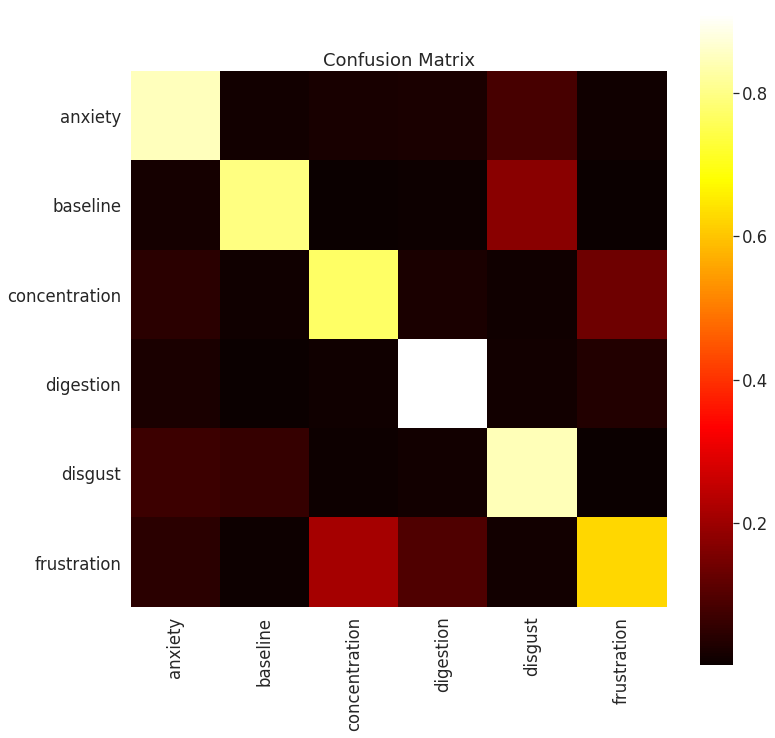

In [10]:
conf_mat = confusion_matrix(y_test, y_pred)
conf_mat = conf_mat.astype(dtype=np.float16)
for row in range(conf_mat.shape[0]):
    conf_mat[row,:] = conf_mat[row,:] / sum(conf_mat[row,:])

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(12, 12))
plt.title('Confusion Matrix')
sns.heatmap(conf_mat, cmap='hot', square=True, xticklabels=classes, yticklabels=classes, label='large')
plt.show()

In [11]:
acc = str(round(accuracy_score(y_test, y_pred), 4))
f1 = str(round(f1_score(y_test, y_pred, average='weighted'), 4))
print('Accuracy: {}'.format(acc))
print('F1 Score: {}'.format(f1))

Accuracy: 0.8218
F1 Score: 0.8213


Not bad. Digestion seems to be the easiest to classify, which makes sense since there is physical stimulation in that case. It seems concentration and frustration produced some similar responses. Overall, I was pretty impressed to see results this good, but I think they will go down given the chance to try cross validation.

### Concerns / steps to improve analysis

I'll take some time to mention some things I noticed when looking at the data.

One potential major issue is **how the stethoscope was placed for data collection**. If you look at both audio channels, sometimes one is noisier than the other, and even captures different looking data. I'd imagine this happens because of the location where each probe is placed. This could be a source of systematic error, which could throw results into question. One way to test this would be to use cross validation and split based on individual participants. There could also be some variance in the noise floor, which might throw the envelope detection off although I don't think it is very likely. I high pass filtered at 10 hertz to remove any steady state offset in the signal.

One way to produce some more convincing results to validate your data size would be to create a **learning curve plot** see: https://scikit-learn.org/stable/modules/learning_curve.html. You increase data size by 0.1 of 1.0 and train the model. Eventually you would hope to see a plateau. If the curve is still increasing, then you might be able to justify more data collection. Either that or discover you have collected enough data to estimate a population.

It's a good idea to **evaluate each participant** and use majority voting for each time step and see if it gets the correct classification when looking at all samples as a whole. This could also allow you to see problematic data to test what is going wrong somewhere.